In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
train_dir = 'train'
test_dir = 'test'
val_dir='validation'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size=32,
    image_size=(224, 224),
    seed=123,
    shuffle=True,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    batch_size=32,
    image_size=(224, 224),
    seed=123,
    shuffle=True,
)

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


In [3]:
import os
class_names = sorted(os.listdir(train_dir))
print("Class Names:", class_names)
num_classes = len(class_names)
print("Number of Classes:", num_classes)

Class Names: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
Number of Classes: 15


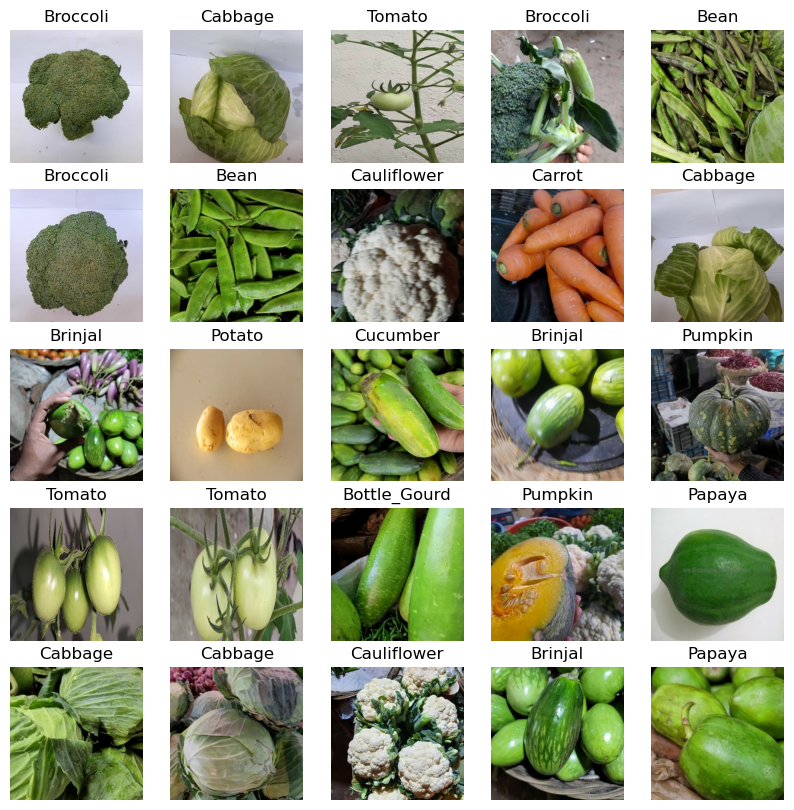

In [4]:
def show_images(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1): 
        for i in range(25): 
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
show_images(train_ds, class_names)
plt.show()

In [5]:
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Dropout(0.25))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(15, activation='softmax'))

In [6]:
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [7]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15163420900855475670
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1733715559
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17109804815456308153
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [8]:
from tensorflow.keras import callbacks
with tf.device('/GPU:0'):
 early_stopping = callbacks.EarlyStopping(patience=3)
 history = model.fit(
     train_ds, 
     epochs=16,  
     validation_data=val_ds,
     callbacks=[early_stopping],
     batch_size=64
 )

Epoch 1/16
469/469 [==============================] - 63s 125ms/step - loss: 4.6657 - accuracy: 0.2537 - val_loss: 2.0490 - val_accuracy: 0.3793
Epoch 2/16
469/469 [==============================] - 57s 122ms/step - loss: 1.5064 - accuracy: 0.4987 - val_loss: 1.6098 - val_accuracy: 0.5590
Epoch 3/16
469/469 [==============================] - 57s 122ms/step - loss: 0.9639 - accuracy: 0.6921 - val_loss: 1.1363 - val_accuracy: 0.6917
Epoch 4/16
469/469 [==============================] - 57s 122ms/step - loss: 0.5737 - accuracy: 0.8229 - val_loss: 0.8530 - val_accuracy: 0.7583
Epoch 5/16
469/469 [==============================] - 57s 122ms/step - loss: 0.3734 - accuracy: 0.8801 - val_loss: 0.6194 - val_accuracy: 0.8470
Epoch 6/16
469/469 [==============================] - 57s 121ms/step - loss: 0.3182 - accuracy: 0.9007 - val_loss: 0.5640 - val_accuracy: 0.8453
Epoch 7/16
469/469 [==============================] - 57s 121ms/step - loss: 0.2235 - accuracy: 0.9299 - val_loss: 0.7249 - val_ac

In [9]:
model.save("model.h5")

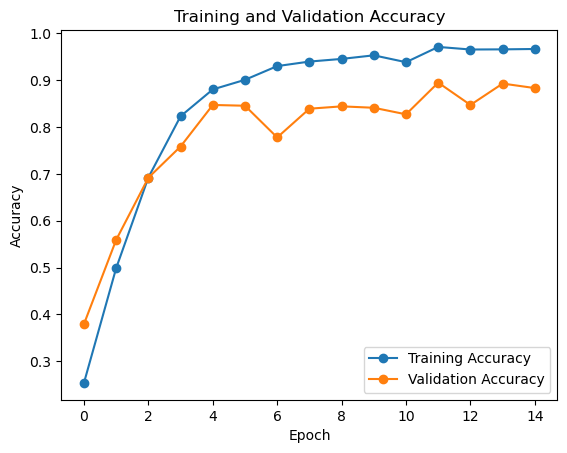

In [10]:
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

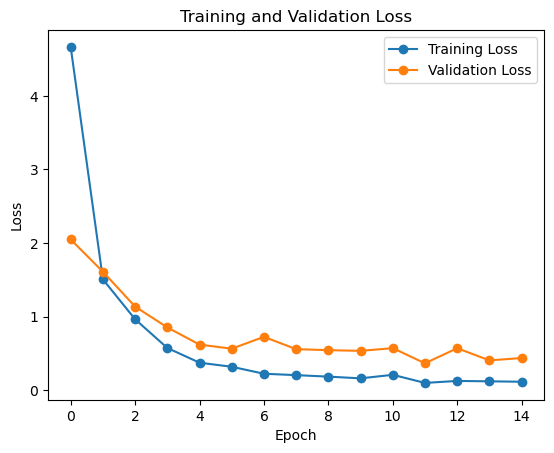

In [11]:
plt.plot(history.history['loss'], label='Training Loss',marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss',marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [12]:
model_path = 'model.h5'
model = tf.keras.models.load_model(model_path)

In [13]:
from sklearn.metrics import classification_report
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size=32,
    image_size=(224, 224),
    seed=42,
)



Found 3000 files belonging to 15 classes.


In [24]:
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_classes = tf.argmax(predictions, axis=1)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(predicted_classes.numpy())
true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
report = classification_report(true_labels_np, predicted_labels_np)

print(report)

1/1 [==============================] - 0s 27ms/step
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       200
           1       0.91      0.94      0.92       200
           2       0.92      0.92      0.92       200
           3       0.79      0.82      0.80       200
           4       0.84      0.92      0.88       200
           5       0.79      0.86      0.82       200
           6       0.92      0.95      0.94       200
           7       0.96      0.97      0.96       200
           8       0.89      0.76      0.82       200
           9       0.93      0.85      0.89       200
          10       0.83      0.94      0.88       200
          11       0.92      0.94      0.93       200
          12       0.79      0.89      0.84       200
          13       0.97      0.86      0.91       200
          14       0.94      0.78      0.85       200

    accuracy                           0.88      3000
   macro avg       0.89     

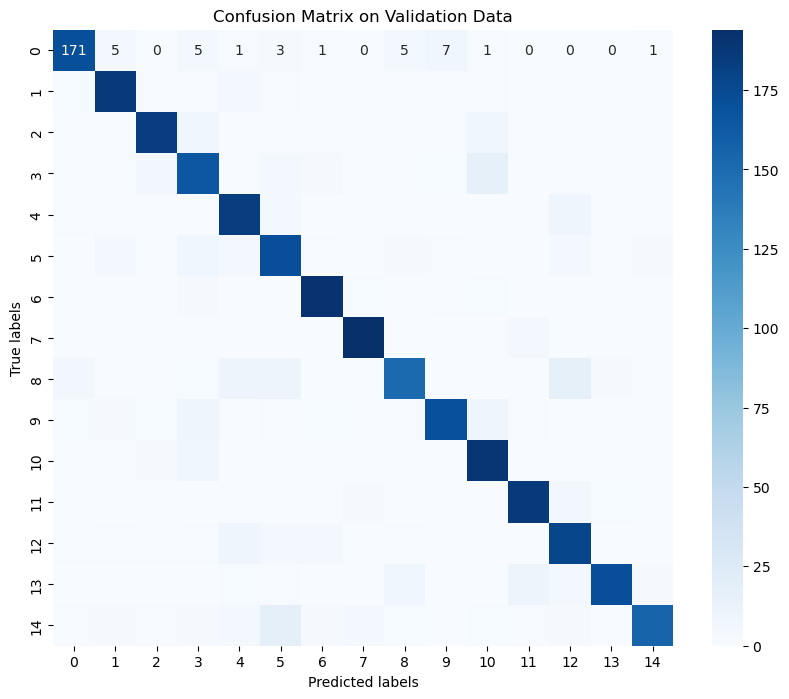

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
true_labels_np = tf.concat(true_labels, axis=0).numpy()
predicted_labels_np = tf.concat(predicted_labels, axis=0).numpy()
conf_matrix = confusion_matrix(true_labels_np, predicted_labels_np)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(15), yticklabels=range(15))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on Test Data')
plt.show()

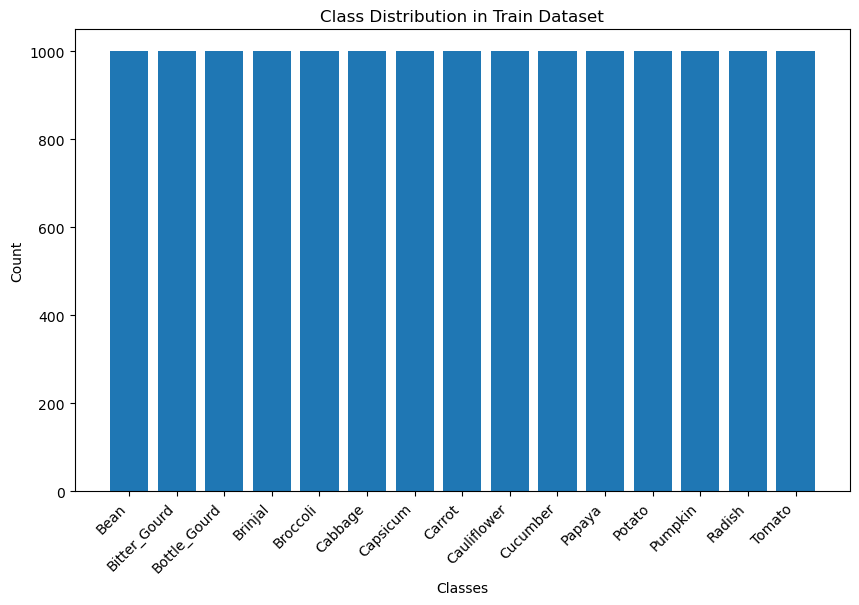

In [18]:
class_names = train_ds.class_names
class_counts = [0] * len(class_names)
for _, labels in train_ds:
    for label in labels:
        class_counts[label] += 1
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution in Train Dataset')
plt.xticks(rotation=45, ha='right')
plt.show()